In [1]:
!pip install matplotlib -q
from yahtzee import Game
from constants import CATEGORIES
from greedy_strategy import greedy_strategy, score_all_rolls
from itertools import combinations_with_replacement, combinations, product
from collections import Counter
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


# 1. Simple greedy strategy
Prioritize expected score of next most imminent roll

## Background: How do the potential scores of various rolls differ?

In [2]:
g = Game()
all_rolls, all_rolls_scores = score_all_rolls(g)

In [7]:
all_rolls_scores[:,0]

array([5, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

(array([ 0.,  0.,  0.,  0.,  1.,  1.,  2.,  3.,  5.,  7.,  9., 11., 14.,
        16., 18., 19., 20., 20., 19., 18., 16., 14., 11.,  9.,  7.,  5.,
         3.,  2.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.        ,  1.02040816,  2.04081633,  3.06122449,  4.08163265,
         5.10204082,  6.12244898,  7.14285714,  8.16326531,  9.18367347,
        10.20408163, 11.2244898 , 12.24489796, 13.26530612, 14.28571429,
        15.30612245, 16.32653061, 17.34693878, 18.36734694, 19.3877551 ,
        20.40816327, 21.42857143, 22.44897959, 23.46938776, 24.48979592,
        25.51020408, 26.53061224, 27.55102041, 28.57142857, 29.59183673,
        30.6122449 , 31.63265306, 32.65306122, 33.67346939, 34.69387755,
        35.71428571, 36.73469388, 37.75510204, 38.7755102 , 39.79591837,
        40.81632653, 41.83673469, 42.85714286, 43.87755102, 44.89795918,
        45.91836735, 46.93877551, 47.95918367, 48.97959184, 50. 

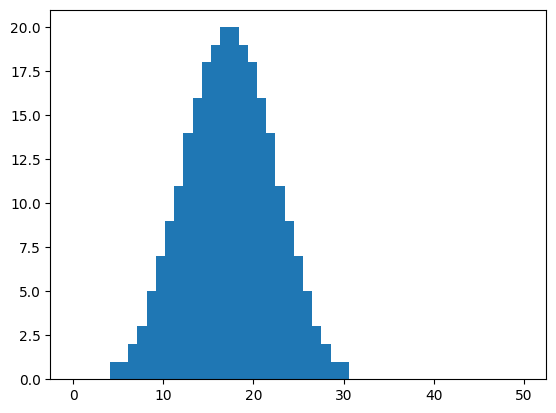

In [20]:
fig, ax = plt.subplots(1, 1)
bins = np.linspace(0, 50)
ax.hist(all_rolls_scores[:,12], bins=bins)

## a. First greedy variant: Prioritize earning upper section bonus

In [2]:
game_states_upper = []

# Use different seed for each iteration
for i in tqdm(range(1, 10000, 5), miniters=10000/100):
    game_states_upper.append(greedy_strategy(start_seed=i, prioritize_upper_section=True))

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [04:42<00:00,  7.08it/s]


In [3]:
df_upper = pd.DataFrame(game_states_upper)
df_upper.drop(columns=['available_categories', 'potential_scores', 'rolls_remaining', 'dice_values'], inplace=True)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   3.,   7.,  16.,  23.,  26.,  37.,  66., 114., 160.,
        287., 302., 288., 129.,  66.,  78.,  99., 123.,  92.,  31.,   1.,
          2.,   2.,   3.,   3.,   1.,   5.,   9.,   4.,   5.,   4.,   4.,
          1.,   1.,   4.,   3.,   1.]),
 array([  0.        ,   8.81632653,  17.63265306,  26.44897959,
         35.26530612,  44.08163265,  52.89795918,  61.71428571,
         70.53061224,  79.34693878,  88.16326531,  96.97959184,
        105.79591837, 114.6122449 , 123.42857143, 132.24489796,
        141.06122449, 149.87755102, 158.69387755, 167.51020408,
        176.32653061, 185.14285714, 193.95918367, 202.7755102 ,
        211.59183673, 220.40816327, 229.2244898 , 238.04081633,
        246.85714286, 255.67346939, 264.48979592, 273.30612245,
        282.12244898, 290.93877551, 299.75510204, 308.57142857,
        317.3877551 , 326.20408163, 335.02040816, 343.83673469,
        352.65306122, 36

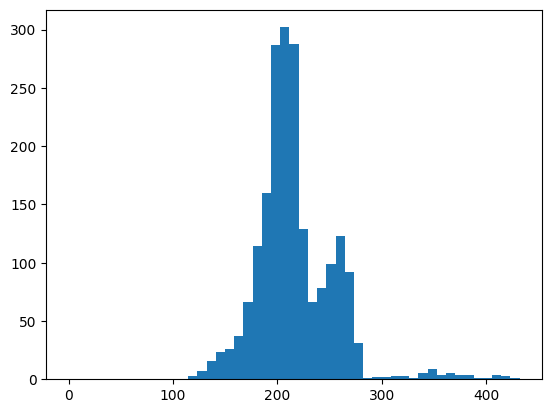

In [38]:
fig, ax = plt.subplots(1, 1)
bins = np.linspace(0, df_upper['final_score'].max())
ax.hist(df_upper['final_score'], bins=bins)

In [67]:
from collections import defaultdict
# Split into scores and score order
round_scores = pd.DataFrame(df_upper['scores'].to_list(), columns = CATEGORIES)

order_round_to_category_dict = defaultdict(list)
order_category_to_round_dict = defaultdict(list)

# score order by col
for i, r in df_upper.iterrows():
    for j, v in enumerate(r['score_order']):
        # Standardize Yahtzee bonuses
        if 'yahtzee, ' in v:
            order_round_to_category_dict[j].append('yahtzee_bonus')
            order_category_to_round_dict['yahtzee_bonus'].append(j)
        else:
            order_round_to_category_dict[j].append(v)
            order_category_to_round_dict[v].append(j)

order_round_to_category_df = pd.DataFrame(order_round_to_category_dict)

(array([577., 447., 264., 112.,  17.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.]),
 <BarContainer object of 12 artists>)

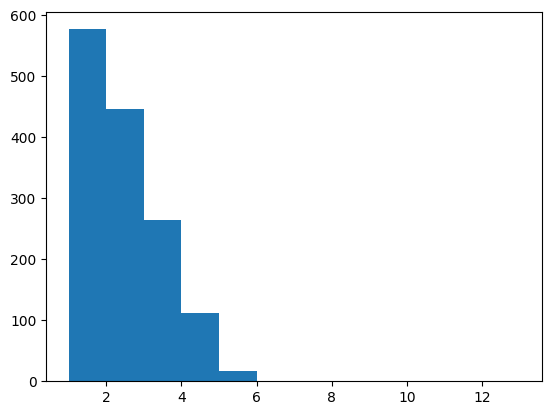

In [76]:
fig, ax = plt.subplots(1, 1)
bins = np.linspace(1, 13, num=13)
ax.hist(order_category_to_round_dict['chance'], bins=bins)

In [45]:
len(df_upper['score_order'].iloc[0])

13

## b. Second greedy variant: Do not prioritize earning upper section bonus

In [ ]:
game_states_no_upper = []

# Use different seed for each iteration
for i in tqdm(range(1, 10000, 5), miniters=10000/100):
    game_states_no_upper.append(greedy_strategy(start_seed=i, prioritize_upper_section=False))